In [ ]:
# get 5 images from each class and labels
import pandas as pd
import os

def get_5_images(cls_name):
    for split in os.listdir(path):
        if split != "single_prompts.csv":
            for c in os.listdir(path + "/" + split):
                if c == cls_name:
                    imgs = os.listdir(path + "/" + split + "/" + c)[:5]
                    imgs = [path + "/" + split + "/" + c + "/" + i for i in imgs]

    return imgs

# get list of images
images = []
labels = []
class_names = pd.read_csv('diffusion_classifier_clip/prompts/clevr_prompts_cone.csv')['class_name'].tolist()
path = '/user/work/ep16475/cobi2_datasets/single_object'
for c in class_names:
    imgs = get_5_images(c)
    images.extend(imgs)
    labels.extend([c for i in range(5)])

print(images)
print(labels)

['/user/work/ep16475/cobi2_datasets/single_object/OOD_test/blue cone/CLEVR_blue_cone_000222.png', '/user/work/ep16475/cobi2_datasets/single_object/OOD_test/blue cone/CLEVR_blue_cone_000189.png', '/user/work/ep16475/cobi2_datasets/single_object/OOD_test/blue cone/CLEVR_blue_cone_000399.png', '/user/work/ep16475/cobi2_datasets/single_object/OOD_test/blue cone/CLEVR_blue_cone_000067.png', '/user/work/ep16475/cobi2_datasets/single_object/OOD_test/blue cone/CLEVR_blue_cone_000235.png', '/user/work/ep16475/cobi2_datasets/single_object/ID_val/blue cube/CLEVR_new_large_blue_metal_cube000099.png', '/user/work/ep16475/cobi2_datasets/single_object/ID_val/blue cube/CLEVR_new_large_blue_rubber_cube000083.png', '/user/work/ep16475/cobi2_datasets/single_object/ID_val/blue cube/CLEVR_new_small_blue_rubber_cube000027.png', '/user/work/ep16475/cobi2_datasets/single_object/ID_val/blue cube/CLEVR_new_small_blue_metal_cube000045.png', '/user/work/ep16475/cobi2_datasets/single_object/ID_val/blue cube/CLEVR_

/tmp/ipykernel_3238374/3804515058.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("seed_2_single.pt"))


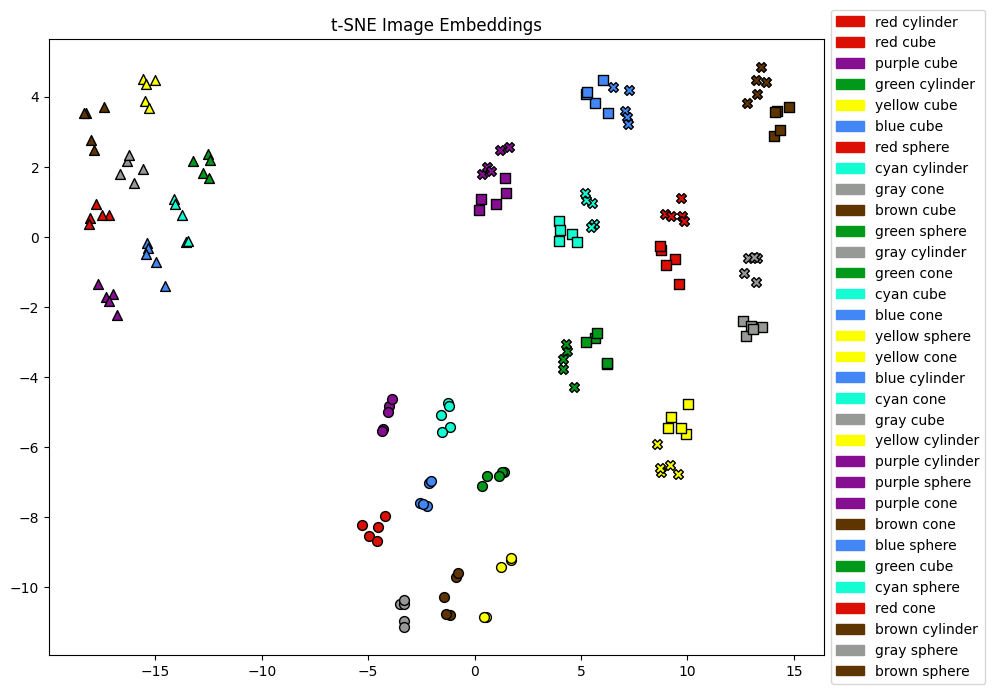

In [29]:
import clip
import torch
from PIL import Image
import glob
import os
import pandas as pd
from matplotlib.patches import Patch

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
model.load_state_dict(torch.load("seed_2_single.pt"))



rows_list = []
image_embeddings = []

for img in images:
    image = transform(Image.open(img)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)[0]
        image_embeddings.append(image_features)

from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(2, perplexity=7)
embs = [torch.flatten(e.cpu()) for e in image_embeddings]
img_embeddings = tsne.fit_transform(np.array(embs))

# Define a mapping for colors based on text
def get_colour(label):
    col = label.split(" ")[0]
    col_dict = {
        'blue': '#4287f5',
        'green': '#02991b',
        'gray': '#969996',
        'purple': '#860f91',
        'red': '#db0f04',
        'yellow': '#fbff00',
        'cyan': '#14fcd2',
        'brown': '#5e3401'
    }
    return col_dict[col]

# Define a mapping for marker shapes based on text
def get_shape(label):
    shape = label.split(" ")[1]
    shape_dict = {
        'cone': '^',
        'cube': 's',
        'sphere': 'o',
        'cylinder': 'X'
    }
    return shape_dict[shape]

# Extract colors from labels
label_to_style = {
    label: (get_colour(label), get_shape(label))
    for label in unique_labels
}

# Unique labels for legend
unique_labels = list(set(labels))

# Create legend patches
patches = [Patch(color=get_colour(label), label=label) for label in unique_labels]

# Plot
fig = plt.figure(figsize=(10, 8))
markers = []
for label, (color, marker) in label_to_style.items():
    indices = [idx for idx, lbl in enumerate(labels) if lbl == label]
    plt.scatter(
        img_embs[indices, 0],
        img_embs[indices, 1],
        label=label,
        c=color,
        marker=marker,
        edgecolor='k',
        s=50,
    )
    markers.append(label.replace(" ", "_"))

# Add legend
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("t-SNE Image Embeddings")
plt.show()




In [25]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
#model, preprocess = clip.load("ViT-B/32", device=device)

prompts = pd.read_csv('diffusion_classifier_clip/prompts/clevr_prompts_cone.csv')['prompt'].tolist()
text = clip.tokenize(prompts).to(device)

with torch.no_grad():
    text_embeddings = model.encode_text(text)

print(text_embeddings[0].shape)
print(image_embeddings[0].shape)
print(image_embeddings[0][0])

torch.Size([512])
torch.Size([512])
tensor(-0.4246, device='cuda:0', dtype=torch.float16)


In [26]:
img_embeddings = torch.stack(image_embeddings, dim=0)
img_embeddings /= img_embeddings.norm(dim = -1, keepdim = True)
text_embeddings /= text_embeddings.norm(dim = -1, keepdim = True)

In [27]:
combined_embeddings = torch.cat([
    img_embeddings,
    text_embeddings
], dim = 0).cpu().numpy()

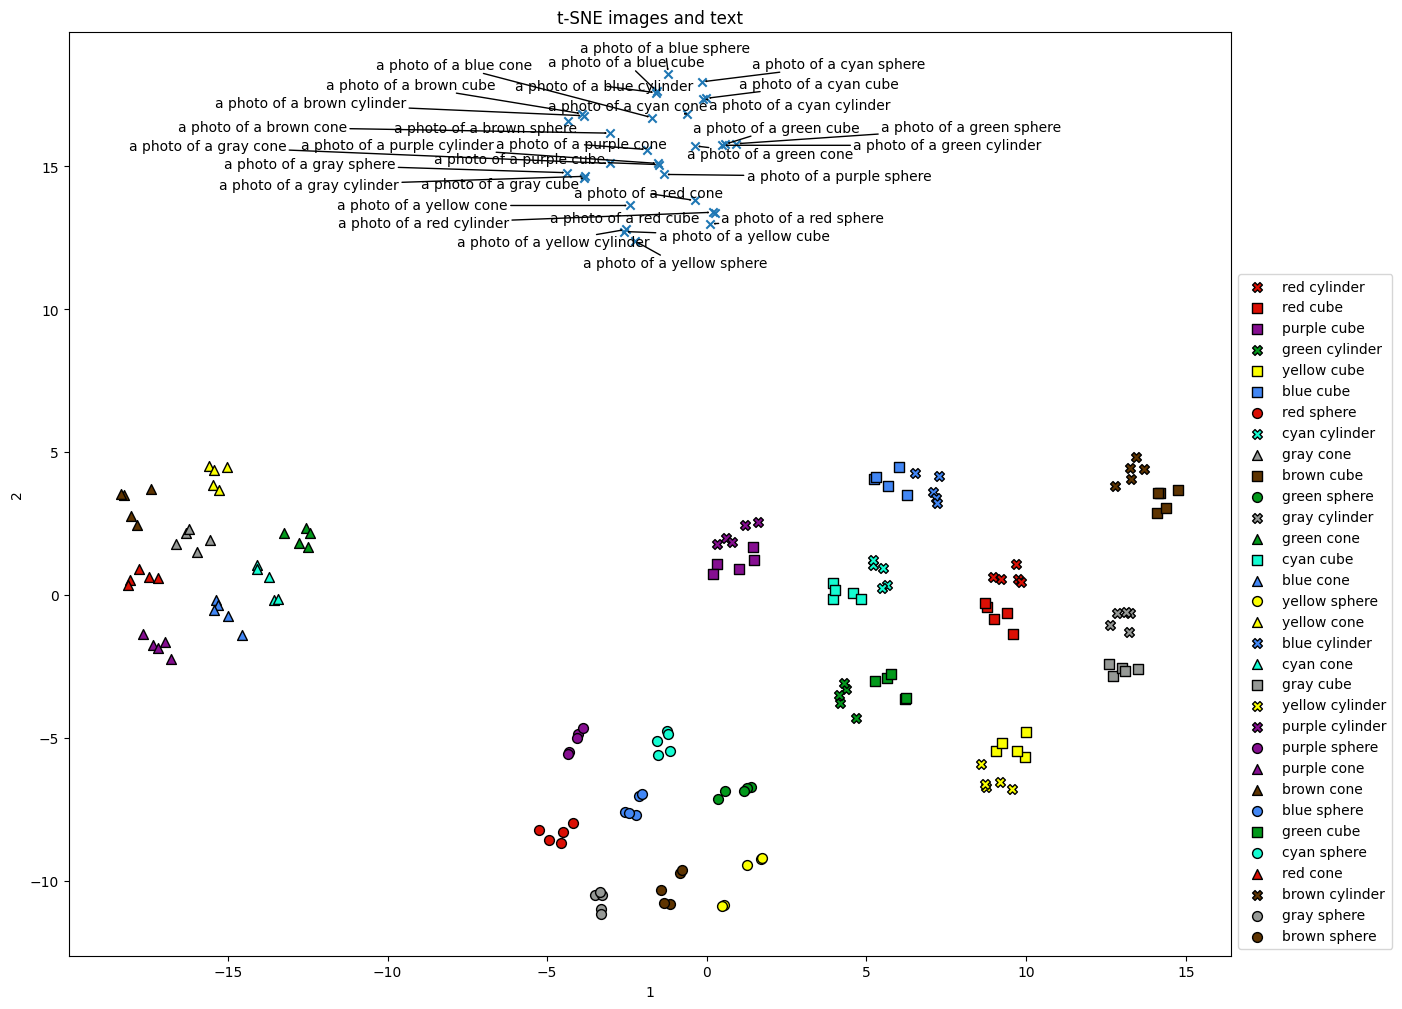

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from adjustText import adjust_text


# Transform embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(combined_embeddings)

img_embs = tsne_result[:len(img_embeddings)]
text_embs = tsne_result[len(img_embeddings):]
# Define a mapping for colors based on text
def get_colour(label):
    col = label.split(" ")[0]
    col_dict = {
        'blue': '#4287f5',
        'green': '#02991b',
        'gray': '#969996',
        'purple': '#860f91',
        'red': '#db0f04',
        'yellow': '#fbff00',
        'cyan': '#14fcd2',
        'brown': '#5e3401'
    }
    return col_dict[col]

# Define a mapping for marker shapes based on text
def get_shape(label):
    shape = label.split(" ")[1]
    shape_dict = {
        'cone': '^',
        'cube': 's',
        'sphere': 'o',
        'cylinder': 'X'
    }
    return shape_dict[shape]

# Extract unique labels
unique_labels = list(set(labels))

# Create a mapping for labels to colors and markers
label_to_style = {
    label: (get_colour(label), get_shape(label))
    for label in unique_labels
}

# Plot
fig = plt.figure(figsize=(15, 12))
markers = []
for label, (color, marker) in label_to_style.items():
    indices = [idx for idx, lbl in enumerate(labels) if lbl == label]
    plt.scatter(
        img_embs[indices, 0],
        img_embs[indices, 1],
        label=label,
        c=color,
        marker=marker,
        edgecolor='k',
        s=50,
    )
    markers.append(label.replace(" ", "_"))
plt.scatter(text_embs[:, 0], text_embs[:, 1], marker='x')

# Annotate texts with dynamic adjustment
texts = []
for i, txt in enumerate(prompts):
    texts.append(plt.text(text_embs[i, 0], text_embs[i, 1], txt, ha='right'))

# Adjust text positions to minimize overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

# Add legend
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.title("t-SNE images and text")
plt.xlabel("1")
plt.ylabel("2")
plt.show()


# Relational

In [33]:
# get 5 images from each class
import pandas as pd
import os

# get list of images
images = []
labels = []
#class_names = pd.read_csv('diffusion_classifier_clip/prompts/clevr_prompts_cone.csv')['class_name'].tolist()
path = '/user/work/ep16475/cobi2_datasets/relational'

for split in os.listdir(path):
    print(split)
    if split != "metadata":
        if split == "train":
            for c in os.listdir(path + "/" + split):
                print("in train")
                print(c)
                if c not in labels and 'left' in c:
                    imgs = os.listdir(path + "/" + split + "/" + c)[:5]
                    imgs = [path + "/" + split + "/" + c + "/" + i for i in imgs]
                    images.extend(imgs)
                    labels.extend([c for i in range(5)])
        else:
            for c in os.listdir(path + "/" + split):
                    print("in others")
                    print(c)
                    c2 = os.listdir(path +"/"+split+ "/" + c)[0]
                    print(c2)
                    if c2 not in labels and 'left' in c2:
                        imgs = os.listdir(path + "/" + split + "/" + c + "/" + c2)[:5]
                        imgs = [path + "/" + split + "/" + c + "/" +c2 + "/" + i for i in imgs]
                        images.extend(imgs)
                        labels.extend([c2 for i in range(5)])
        
print(labels)
print(len(labels))
print(len(images))
print(images)
sorted_labels, sorted_images = zip(*sorted(zip(labels, images)))
images = sorted_images
labels = sorted_labels

metadata
rel_prompts
in others
beth_rel_prompts_val_gen
sphere_right_cylinder.csv
in others
train_rel_prompts
cube_right_sphere.csv
in others
beth_rel_prompts_val
sphere_right_cylinder.csv
in others
train_rel_prompts_gen
cube_right_sphere.csv
in others
test_rel_prompts_gen
cylinder_right_cube.csv
in others
test_rel_prompts
cylinder_right_cube.csv
train
in train
cube left sphere
in train
cylinder left sphere
in train
sphere left cone
in train
cube right sphere
in train
sphere left cube
in train
sphere right cube
in train
cylinder left cube
in train
cylinder left cone
in train
cone right sphere
in train
cone right cylinder
in train
cube right cylinder
id_test
in others
cube_right_sphere
cube right sphere
in others
cylinder_left_cone
cylinder left cone
in others
cube_left_sphere
cube left sphere
in others
cone_right_sphere
cone right sphere
in others
cylinder_left_sphere
cylinder left sphere
in others
cone_right_cylinder
cone right cylinder
in others
sphere_right_cube
sphere right cube
in

/tmp/ipykernel_3238374/1331560566.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_finetuned.load_state_dict(torch.load("/user/work/ep16475/clip_rel_5_seed_models/

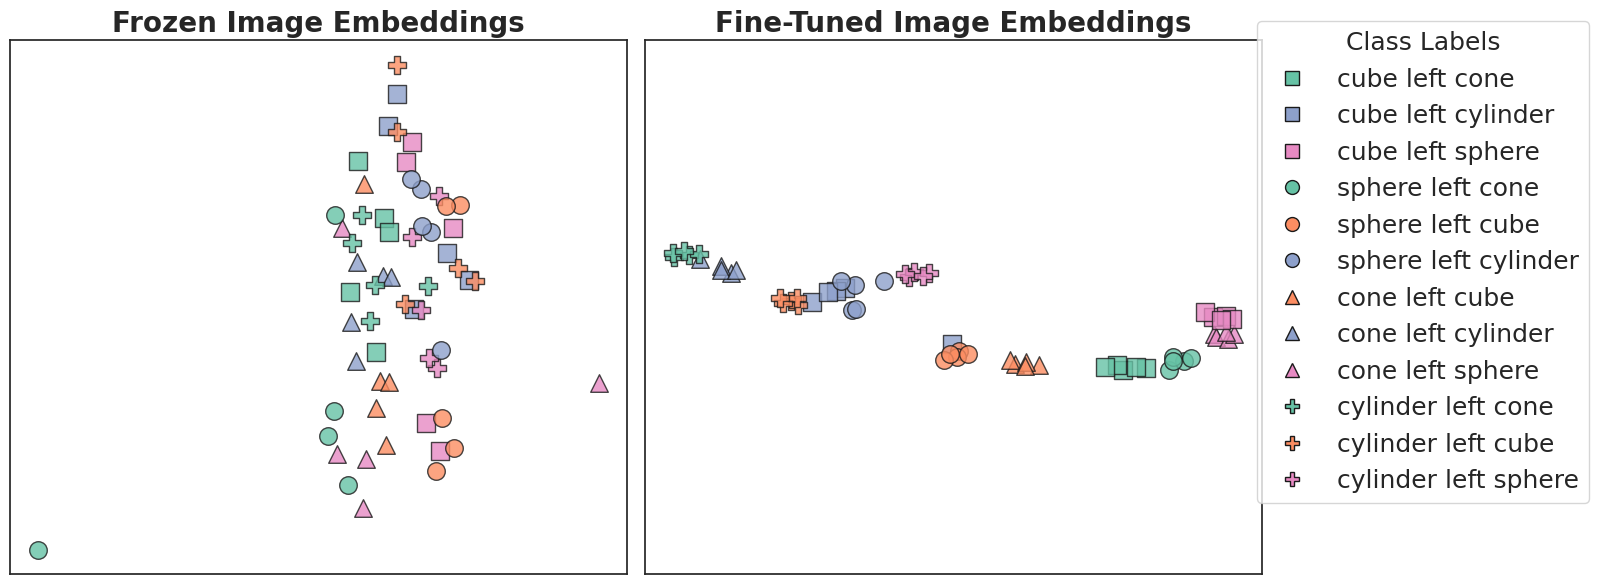

In [34]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from PIL import Image

# Set device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model
model_base, transform = clip.load("ViT-B/32", device=device)

# Clone model for fine-tuned version
model_finetuned, _ = clip.load("ViT-B/32", device=device)
model_finetuned.load_state_dict(torch.load("/user/work/ep16475/clip_rel_5_seed_models/clip_rel_seed_1.pt"))

# Initialize lists for embeddings
image_embeddings_base = []
image_embeddings_finetuned = []

# Define marker shapes for different first words in the label
shape_map = {
    "cube": "s",      # Square
    "sphere": "o",    # Circle
    "cone": "^",      # Triangle
    "cylinder": "P"   # Fat Cross
}

# Extract unique third words for color mapping
third_words = sorted(set(label.split()[2].lower() if len(label.split()) > 2 else "default" for label in labels))
color_palette = sns.color_palette("Set2", len(third_words))
color_map = {word: color_palette[i] for i, word in enumerate(third_words)}

# Process and encode images for both models
markers = []
colors = []
for img_path, label in zip(images, labels):
    image = transform(Image.open(img_path)).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features_base = model_base.encode_image(image)
        image_features_finetuned = model_finetuned.encode_image(image)

    image_embeddings_base.append(image_features_base)
    image_embeddings_finetuned.append(image_features_finetuned)
    
    # Determine marker based on the first word in the label
    first_word = label.split()[0].lower()
    markers.append(shape_map.get(first_word, "o"))  # Default to circle if not in shape_map
    
    # Assign colors based on the third word
    third_word = label.split()[2].lower() if len(label.split()) > 2 else "default"
    colors.append(color_map.get(third_word, color_palette[0]))

# Convert embeddings to NumPy arrays
image_embeddings_base_np = np.array([torch.flatten(e.cpu()).numpy() for e in image_embeddings_base])
image_embeddings_finetuned_np = np.array([torch.flatten(e.cpu()).numpy() for e in image_embeddings_finetuned])

# Perform t-SNE for both sets of embeddings
tsne = TSNE(n_components=2, perplexity=7, random_state=42)
tsne_base = tsne.fit_transform(image_embeddings_base_np)
tsne_finetuned = tsne.fit_transform(image_embeddings_finetuned_np)

# Configure plot aesthetics
sns.set(style="white")  # Clean white background, no gridlines

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100, sharey=True)  # Share y-axis for better comparison

# Plot base model t-SNE
for i, marker in enumerate(markers):
    axes[0].scatter(tsne_base[i, 0], tsne_base[i, 1], c=[colors[i]], marker=marker, edgecolors='k', alpha=0.8, s=160)
axes[0].set_title("Frozen Image Embeddings", fontsize=20, fontweight='bold')
axes[0].grid(False)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot fine-tuned model t-SNE
for i, marker in enumerate(markers):
    axes[1].scatter(tsne_finetuned[i, 0], tsne_finetuned[i, 1], c=[colors[i]], marker=marker, edgecolors='k', alpha=0.8, s=160)
axes[1].set_title("Fine-Tuned Image Embeddings", fontsize=20, fontweight='bold')
axes[1].grid(False)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Create a unified legend combining shape and color
legend_elements = []
for shape_name, shape in shape_map.items():
    for word, color in color_map.items():
        if shape_name != word:
            legend_elements.append(Line2D([0], [0], marker=shape, color='w', markerfacecolor=color, markeredgecolor='k', markersize=10, label=f"{shape_name} left {word}"))

fig.legend(handles=legend_elements, title="Class Labels", loc="center right", bbox_to_anchor=(1.15, 0.55), fontsize=18, title_fontsize=18)

# Adjust layout to ensure everything fits well
plt.tight_layout(rect=[0, 0, 0.92, 1])  # Leaves space for the legend on the right

# Show the plot
plt.show()


/tmp/ipykernel_3238374/667471556.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_finetuned.load_state_dict(torch.load("/user/work/ep16475/clip_rel_5_seed_models/c

cone left cube
cone left cube
cone left cube
cone left cube
cone left cube
cone left cylinder
cone left cylinder
cone left cylinder
cone left cylinder
cone left cylinder
cone left sphere
cone left sphere
cone left sphere
cone left sphere
cone left sphere
cube left cone
cube left cone
cube left cone
cube left cone
cube left cone
cube left cylinder
cube left cylinder
cube left cylinder
cube left cylinder
cube left cylinder
cube left sphere
cube left sphere
cube left sphere
cube left sphere
cube left sphere
cylinder left cone
cylinder left cone
cylinder left cone
cylinder left cone
cylinder left cone
cylinder left cube
cylinder left cube
cylinder left cube
cylinder left cube
cylinder left cube
cylinder left sphere
cylinder left sphere
cylinder left sphere
cylinder left sphere
cylinder left sphere
sphere left cone
sphere left cone
sphere left cone
sphere left cone
sphere left cone
sphere left cube
sphere left cube
sphere left cube
sphere left cube
sphere left cube
sphere left cylinder
sphe

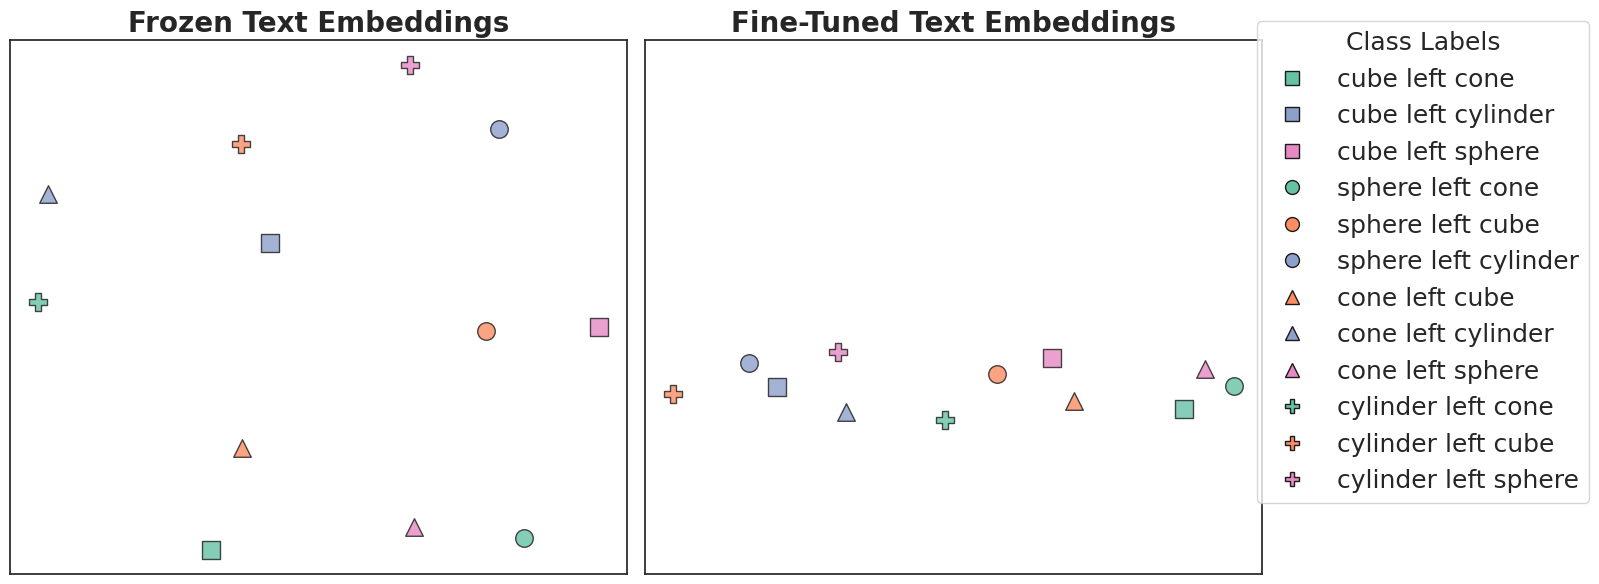

In [36]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from PIL import Image

# Set device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model
model_base, transform = clip.load("ViT-B/32", device=device)

# Clone model for fine-tuned version
model_finetuned, _ = clip.load("ViT-B/32", device=device)
model_finetuned.load_state_dict(torch.load("/user/work/ep16475/clip_rel_5_seed_models/clip_rel_seed_1.pt"))

# Initialize lists for embeddings
image_embeddings_base = []
image_embeddings_finetuned = []

# Define marker shapes for different first words in the label
shape_map = {
    "cube": "s",      # Square
    "sphere": "o",    # Circle
    "cone": "^",      # Triangle
    "cylinder": "P"   # Fat Cross
}

# Extract unique third words for color mapping
third_words = sorted(set(label.split()[2].lower() if len(label.split()) > 2 else "default" for label in labels))
color_palette = sns.color_palette("Set2", len(third_words))
color_map = {word: color_palette[i] for i, word in enumerate(third_words)}

# Process and encode images for both models
markers = []
colors = []
done_labels = []
for img_path, label in zip(images, labels):
    print(label)
    image = transform(Image.open(img_path)).unsqueeze(0).to(device)
    text = clip.tokenize(label).to(device)
    with torch.no_grad():
        image_features_base = model_base.encode_text(text)
        image_features_finetuned = model_finetuned.encode_text(text)

    if label not in done_labels:
        image_embeddings_base.append(image_features_base)
        image_embeddings_finetuned.append(image_features_finetuned)
        done_labels.append(label)
    # Determine marker based on the first word in the label
        first_word = label.split()[0].lower()
        markers.append(shape_map.get(first_word, "o"))  # Default to circle if not in shape_map
        
        # Assign colors based on the third word
        third_word = label.split()[2].lower() if len(label.split()) > 2 else "default"
        colors.append(color_map.get(third_word, color_palette[0]))

# Convert embeddings to NumPy arrays
image_embeddings_base_np = np.array([torch.flatten(e.cpu()).numpy() for e in image_embeddings_base])
image_embeddings_finetuned_np = np.array([torch.flatten(e.cpu()).numpy() for e in image_embeddings_finetuned])

# Perform t-SNE for both sets of embeddings
tsne = TSNE(n_components=2, perplexity=7, random_state=42)
tsne_base = tsne.fit_transform(image_embeddings_base_np)
tsne_finetuned = tsne.fit_transform(image_embeddings_finetuned_np)

# Configure plot aesthetics
sns.set(style="white")  # Clean white background, no gridlines

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100, sharey=True)  # Share y-axis for better comparison

# Plot base model t-SNE
for i, marker in enumerate(markers):
    axes[0].scatter(tsne_base[i, 0], tsne_base[i, 1], c=[colors[i]], marker=marker, edgecolors='k', alpha=0.8, s=160)
axes[0].set_title("Frozen Text Embeddings", fontsize=20, fontweight='bold')
axes[0].grid(False)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot fine-tuned model t-SNE
for i, marker in enumerate(markers):
    axes[1].scatter(tsne_finetuned[i, 0], tsne_finetuned[i, 1], c=[colors[i]], marker=marker, edgecolors='k', alpha=0.8, s=160)
axes[1].set_title("Fine-Tuned Text Embeddings", fontsize=20, fontweight='bold')
axes[1].grid(False)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Create a unified legend combining shape and color
legend_elements = []
for shape_name, shape in shape_map.items():
    for word, color in color_map.items():
        if shape_name != word:
            legend_elements.append(Line2D([0], [0], marker=shape, color='w', markerfacecolor=color, markeredgecolor='k', markersize=10, label=f"{shape_name} left {word}"))

fig.legend(handles=legend_elements, title="Class Labels", loc="center right", bbox_to_anchor=(1.15, 0.55), fontsize=18, title_fontsize=18)

# Adjust layout to ensure everything fits well
plt.tight_layout(rect=[0, 0, 0.92, 1])  # Leaves space for the legend on the right

# Show the plot
plt.show()
